<a href="https://colab.research.google.com/github/ravichas/bifx-546/blob/main/Notebooks/Chapter14_SimpleLinearRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# ==== Course setup: safe clone + cd + import path ====
import os
import sys

REPO_URL = "https://github.com/joelgrus/data-science-from-scratch.git"
REPO_DIR = "data-science-from-scratch"

# 1. If we're *anywhere inside* the repo, move to the parent directory first
cwd = os.getcwd()
if REPO_DIR in cwd.split(os.sep):
    parts = cwd.split(os.sep)
    # Walk up until we are at .../data-science-from-scratch
    while parts and parts[-1] != REPO_DIR:
        parts.pop()
    # Now go to the directory *above* the repo
    parent_dir = os.sep.join(parts[:-1]) or "/"
    os.chdir(parent_dir)
    print(f"Moved to parent directory: {os.getcwd()}")

# 2. Clone only if needed
if not os.path.exists(REPO_DIR):
    print("Cloning repo...")
    !git clone {REPO_URL}
else:
    print(f"{REPO_DIR} already exists — skipping clone.")

# 3. cd into the repo (this is where you'll live most of the time)
%cd {REPO_DIR}

# 4. Ensure the repo is importable (for scratch.linear_algebra, etc.)
if os.getcwd() not in sys.path:
    sys.path.append(os.getcwd())
    print("Added repo to sys.path")

Moved to parent directory: /content
data-science-from-scratch already exists — skipping clone.
/content/data-science-from-scratch


# Function explanations

# Predict
$ \hat{y_i} = \beta x_i + \alpha$

# Error

This compares:
* predicted value $\hat{y_i}$
* actual value $y_i$

So error is:

$\text{error}_i = \hat y_i - y_i$
* If positive: prediction is too high
* If negative: prediction is too low

# Sum of Squares

This loops over all paired data points $(x_i, y_i)$ and:

1.	computes the error
2.	squares it (so negatives don’t cancel positives, and big mistakes count more)
3.	adds them up

So it calculates:
$\sum_{i=1}^n (\hat{y_i} - y_i)^2$

This is the quantity we want to minimize. The “best” line is the one with the smallest total squared error.


# Least Squares Fit

This finds the values of alpha and beta that minimize the total squared error above.
* beta (slope) is computed using correlation and standard deviations:
* correlation says “how strongly x and y move together”
* the SD ratio adjusts for scale/units
* alpha (intercept) is chosen so the fitted line passes through the point:
$(\text{mean}(x), \text{mean}(y)$)

So after this runs, you have the best-fit line:
$\hat{y} = \beta x + \alpha$

In [83]:
def predict(alpha: float, beta: float, x_i: float) -> float:
    return beta * x_i + alpha

def error(alpha: float, beta: float, x_i: float, y_i: float) -> float:
    """
    The error from predicting beta * x_i + alpha
    when the actual value is y_i
    """
    return predict(alpha, beta, x_i) - y_i

from scratch.linear_algebra import Vector

def sum_of_sqerrors(alpha: float, beta: float, x: Vector, y: Vector) -> float:
    return sum(error(alpha, beta, x_i, y_i) ** 2
               for x_i, y_i in zip(x, y))

from typing import Tuple
from scratch.linear_algebra import Vector
from scratch.statistics import correlation, standard_deviation, mean

def least_squares_fit(x: Vector, y: Vector) -> Tuple[float, float]:
    """
    Given two vectors x and y,
    find the least-squares values of alpha and beta
    """
    beta = correlation(x, y) * standard_deviation(y) / standard_deviation(x)
    alpha = mean(y) - beta * mean(x)
    return alpha, beta


In [84]:
x = [i for i in range(-100, 110, 10)]
y = [3 * i - 5 for i in x]

In [85]:
import pandas as pd
df = pd.DataFrame({'x': x , 'y':y})
df.head()

,x,y
0,-100,-305
1,-90,-275
2,-80,-245
3,-70,-215
4,-60,-185


The function that we are fitting is:
$\hat{y} = \beta x + \alpha$

In [86]:
# Should find that y = 3x - 5
lsq_fit = least_squares_fit(x, y)
print('Intercept, Slope: ', lsq_fit)
assert lsq_fit == (-5, 3)

Intercept, Slope:  (-5.0, 3.0)


# Computation of $R^2$

$$R^2 = 1 - \frac{SSE}{TSS}$$

$$ SSE = \sum_{i=1}^n (\hat{y_i} - y_i)^2$$

$$ TSS = \sum_{i=1}^n (y_i - \bar y)^2 $$

Interpretation:

*	SSE/TSS = fraction of the original variation that’s still left over after using the model
*	1 - SSE/TSS = fraction of variation explained by the model

So $R^2$ answers:

“How much better is this line than just predicting the mean \bar y for everyone?”

# Assumptions of LSQ Model

**Assumption A:** No perfect multicollinearity (linear independence)
*	In multiple regression, the columns of X must not be exact linear combinations of each other.
*	If num_acquaintances = num_friends always, you can’t uniquely estimate separate coefficients.
*	Symptoms: unstable coefficients, huge standard errors, software warnings (“singular matrix”).

Class phrase: “If two columns carry the same information, the model can’t decide how to split credit.”

Assumption B **bold text**: Predictors uncorrelated with the error term (exogeneity)
*	LSQ assumes the predictors are not systematically related to the “stuff we didn’t include.”
*	If an omitted factor affects y and is correlated with x, your coefficient is biased.

Your example (great): work hours is omitted, affects minutes (negative), correlated with friends (positive) → LSQ for friends is biased downward.

In [87]:
from scratch.statistics import num_friends_good, daily_minutes_good

alpha, beta = least_squares_fit(num_friends_good, daily_minutes_good)

print('alpha or intercept', alpha)
print('beta or slope', beta)

assert 22.9 < alpha < 23.0
assert 0.9 < beta < 0.905

alpha or intercept 22.947552413468976
beta or slope 0.9038659456058725


In [88]:
from scratch.statistics import de_mean

def total_sum_of_squares(y: Vector) -> float:
    """the total squared variation of y_i's from their mean"""
    return sum(v ** 2 for v in de_mean(y))

def r_squared(alpha: float, beta: float, x: Vector, y: Vector) -> float:
    """
    the fraction of variation in y captured by the model, which equals
    1 - the fraction of variation in y not captured by the model
    """
    return 1.0 - (sum_of_sqerrors(alpha, beta, x, y) /
                  total_sum_of_squares(y))

rsq = r_squared(alpha, beta, num_friends_good, daily_minutes_good)
assert 0.328 < rsq < 0.330

#Method 1: Least Squares (closed-form):

*	Assumes a linear model
*	Uses algebra + calculus
*	Solves equations exactly
*	One shot → get $\alpha$, $\beta$

#Method 2: Gradient Descent (numerical optimization)

*	Assumes the same linear model
*	Defines a loss function
*	Uses gradients to iteratively improve guesses
*	Approximates the solution step-by-step

Same goal. Same model. Different approach.

# Another way to look at it

`In linear regression, we can sometimes solve for the best parameters exactly using algebra; that’s least squares. Gradient descent instead treats parameter fitting as an optimization problem: we start with a random guess and repeatedly adjust the parameters in the direction that reduces the error. For linear regression both approaches reach the same solution, but gradient descent generalizes to models where no closed-form solution exists.`

Here are the details:

* Model (same as before) $\hat{y} = \alpha + \beta x$

* Loss function: $L(\alpha,\beta) = \sum_i (\hat{y_i} - y_i)^2$

Goal:
Find $\alpha$, $\beta$ that minimize this loss.


Text(0.5, 1.0, 'num_friends_good vs daily_minutes_good')

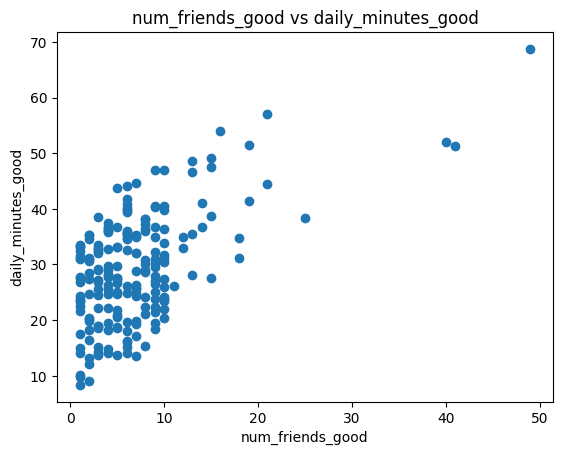

In [89]:
# input data
df1 = pd.DataFrame({'x': num_friends_good,
                    'y': daily_minutes_good})

import matplotlib.pyplot as plt

plt.scatter(num_friends_good, daily_minutes_good)
plt.xlabel("num_friends_good")
plt.ylabel("daily_minutes_good")
plt.title("num_friends_good vs daily_minutes_good")


For linear regression with one feature, we predict:
$\hat{y_i} = \alpha + \beta x_i$

Define the error (residual):
$e_i = \hat y_i - y_i = (\alpha + \beta x_i - y_i)$

The total loss (sum of squared errors) is:
$L(\alpha,\beta) = \sum_{i=1}^n e_i^2$

## Derivative w.r.t. $\alpha$

Use chain rule:
$\frac{\partial L}{\partial \alpha}
= \sum_{i=1}^n \frac{\partial}{\partial \alpha}(e_i^2)$
For each term:
* $\frac{\partial}{\partial \alpha}(e_i^2)=2e_i \cdot \frac{\partial e_i}{\partial \alpha}$
* but $e_i = \alpha + \beta x_i - y_i, so \frac{\partial e_i}{\partial \alpha}=1$

So:
\frac{\partial L}{\partial \alpha} = \sum_{i=1}^n 2e_i

That is exactly what your code computes:



```
grad_a = sum(2 * error(alpha, beta, x_i, y_i) for ...)
```


## Derivative w.r.t. \beta

Similarly:
$\frac{\partial L}{\partial \beta}
= \sum_{i=1}^n 2e_i \cdot \frac{\partial e_i}{\partial \beta}$

But $\frac{\partial e_i}{\partial \beta} = x_i$

So:
$\frac{\partial L}{\partial \beta} = \sum_{i=1}^n 2e_i x_i$

Which matches:

```
grad_b = sum(2 * error(alpha, beta, x_i, y_i) * x_i for ...)
```

2) What are we optimizing?

We are optimizing (minimizing) the loss function:

$L(\alpha,\beta) = \sum_{i=1}^n (\alpha + \beta x_i - y_i)^2$

In words:

“Find the line $y = \alpha + \beta x$ that makes the total squared prediction error as small as possible.”

That’s exactly the same objective as least squares.

What is being updated?
*	Data ($x_i,y_i$) are fixed.
*	Parameters $\alpha,\beta$ are what we change to reduce the loss.

Gradient descent does:
$(\alpha,\beta) \leftarrow (\alpha,\beta) - \eta \left(\frac{\partial L}{\partial \alpha}, \frac{\partial L}{\partial \beta}\right)$

So the gradient tells you the direction that increases the loss fastest; subtracting it moves you toward lower loss.



# Take Home

`Least squares gives the best-fit line in one formula; gradient descent finds the same best-fit line by iteratively minimizing the squared error.`

# Two key differences:

1.   Least squares shows there is an exact solution for linear regression.
2.   Gradient descent teaches a general optimization tool used everywhere in ML.

“We’re searching over the space of all lines y=\alpha+\beta x. Each line corresponds to a point (\alpha,\beta). Gradient descent moves that point step-by-step to the location where the squared-error loss is smallest—i.e., the best-fitting line.”

The key step is

gradient_step(v, gradient, step_size) returns:
$v_{\text{new}} = v + \text{step_size} \cdot \text{gradient}$

Here step_size = -learning_rate, so:

$[\alpha,\beta] \leftarrow [\alpha,\beta] - \eta [\frac{\partial L}{\partial \alpha}, \frac{\partial L}{\partial \beta}]$

In [90]:
import random
import tqdm
from scratch.gradient_descent import gradient_step

num_epochs = 10000
random.seed(0)

guess = [random.random(), random.random()]  # choose random value to start

learning_rate = 0.00001

with tqdm.trange(num_epochs) as t:
    for _ in t:
        alpha, beta = guess

        # Partial derivative of loss with respect to alpha
        grad_a = sum(2 * error(alpha, beta, x_i, y_i)
                      for x_i, y_i in zip(num_friends_good,
                                          daily_minutes_good))

        # Partial derivative of loss with respect to beta
        grad_b = sum(2 * error(alpha, beta, x_i, y_i) * x_i
                      for x_i, y_i in zip(num_friends_good,
                                          daily_minutes_good))

        # Compute loss to stick in the tqdm description
        loss = sum_of_sqerrors(alpha, beta,
                                num_friends_good, daily_minutes_good)
        t.set_description(f"loss: {loss:.3f}")

        # Finally, update the guess
        guess = gradient_step(guess, [grad_a, grad_b], -learning_rate)

# We should get pretty much the same results:
alpha, beta = guess
print('alpha, beta: ', alpha and beta)
assert 22.9 < alpha < 23.0
assert 0.9 < beta < 0.905



loss: 13196.619: 100%|██████████| 10000/10000 [00:12<00:00, 787.66it/s]

alpha, beta:  0.9038659662765034
